# Introduction to Deep Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

# Attention Mechanism

Attention mechanism is one of the most fruitful ideas in machine learning of the last few years.
Here we explore the mechanism in the case of RNN cells, while in the next lecture, we are going to revise the Transformer architecture, that deeply changed the way NLP is done these days.

## Bahdanau attention mechanism

Consider the typical problem of a model architecture "Encoder-Decoder" which is designed to translate a sentence from one language to another, for instance.

We put ourselves in the same set as the paper [Bahdanau et al.](https://arxiv.org/abs/1409.0473).

Consider a machine translation problem with a very long sentence.

<p align="center">
    <img width="936" alt="image" src="https://user-images.githubusercontent.com/49638680/205390791-0ba6d930-677d-4b3f-ab1d-8958c25a27ea.png">
</p>

We memorise the input sentence in the encoder state, that is the input of the decoder network. 
Since _latent space_ dimension is fixed, we have the problem of storing information about a very long sentence into one fixed-length vector. This is commonly referred as the "**bottleneck problem**".

**Attention mechanism** has been described to face such an issue. 
With the attention mechanism one actually memorises the input sentence part-by-part and passes it through the decoder consequently. 
This is precisely what makes this model working well with long sentences.

Consider the following example,

_Sentence (it)_: "Oscar salperà per la Martinica a febbraio."

<p align="center">
    <img width="1251" alt="image" src="https://user-images.githubusercontent.com/49638680/205395500-fb4ed855-78d2-42ac-b241-ce3f81713cfb.png">
</p>

The attention mechanism calculates some quantities $c^{<t>}$ called _context_ for the generated word $t$.

For any context, we have _attention weights_ $\alpha^{<t, i>}$, these measure the importance of the word $i$ in the input to generate the output word $t$.

In general, $\alpha^{<t, i>}$ depends on $a^{<i>}$ and $s^{<t-1>}$ (usually the relations are modelled by a trainable neural network).

The importance of this mechanism is due to the fact that one can now look only at the the _attention window_ to determine the context of the output word.

Explicitly,

$$ c^{<t>} = \sum_{i=1} \alpha^{<t, i>} \cdot a^{<i>} \, .$$

A possible formula to define $\alpha^{<t, i>}$ is the so-called _softmax parametrisation_.

$$ \alpha^{<t, i>} := \frac{\exp(e^{<t, i>})}{\sum_{i=1} \exp(e^{<t, i>})}\, .$$

Where $e^{<t, i>}$ are the _embedding vectors_.

To look at something more dynamical, one can focus on the following image.

<p align="center">
    <img width="1024" src="https://miro.medium.com/max/1042/1*SmAeISN5_u_gjiLPUA8qIA.gif">
</p>

---

## Working example: A neural translation task

We are going to build a neural translation model with Bahdanau attention to translate human-readable dates ("7th of June 1990") into machine-readable dates ("1990-06-07"). 

### Import libraries

Let's start by importing the necessary libraries.


In [10]:
import tensorflow as tf
import numpy as np
import random
from tqdm import tqdm

from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow import python as tf_python
import tensorflow.keras.backend as K

from faker import Faker
from babel.dates import format_date
from utils.nmt_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

### Translating Human Readable Dates Into Machine Readable Dates

The model you will build here could also be used to translate from one language to another, such as translating from English to Italian. However, language translation requires massive datasets and usually takes days of training on GPUs. 
Here, to give a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 

The model will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*). The network will translate them into standardised, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 

We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

#### The dataset

We will train the model on a dataset of $10,000$ human readable dates and their equivalent, standardised, machine readable dates. 

Let's run the following cells to load the dataset and print some examples. 

In [3]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 61920.98it/s]


In [4]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

We have loaded:

- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [5]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


We now have:
- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Ty, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

Let's also look at some examples of preprocessed training examples. 

In [6]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Neural Machine Translation with Attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. 
Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


#### Attention Mechanism

In this part, you will implement the Bahdanau attention mechanism.

Here is a figure to remind you how the model works. 
* The diagram on the left shows the attention model. 
* The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
* The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>

In the following are presented some properties of the model that you may find noteworthy.

##### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism

Note that there are two separate LSTMs in this model (see diagram on the left): _pre-attention_ and _post-attention_ LSTMs.

- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps.
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

##### Each time step does not use predictions from the previous time step

Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.

* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

##### Concatenation of hidden states from the forward and backward pre-attention LSTMs

- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

##### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$

Recall the definition of $e$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- $e$ is called the _energies_ variable.
- $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
- $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
- $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
- $e^{\langle t, t' \rangle}$ is then used when computing the attention $a^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

Finally, the diagram on the right of figure $1$ uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
$e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.

Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.

We are going to explain how to use `RepeatVector` and `Concatenation` in Tensorflow below. 

#### Implementation Details
   
Let's implement this neural translator. We will start by implementing two functions: `one_step_attention()` and `model()`.

#### Notation about 'context' and 'c'
- In the lecture slides, the context was denoted $c^{\langle t \rangle}$
- In the code implementation, we are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

#### `one_step_attention` implementation

* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

Without further ado, let's implement `one_step_attention()`. 

* The function `model()` will call the layers in `one_step_attention()` $T_y$ times using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 
* Here's how you can implement layers with shareable weights in Keras:
    1. Define the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables would work.
        - Note that defining these variables inside the scope of the function `model` would technically work, since `model` will then call the `one_step_attention` function.  For the purposes of making grading and troubleshooting easier, we are defining these as global variables.  Note that the automatic grader will expect these to be global variables as well.
    2. Call these objects when propagating the input.
* We have defined the layers you need as global variables. 
    * Please run the following cells to create them.
* Please check the Keras documentation to learn more about these layers.  The layers are functions.  Below are examples of how to call these functions.
    * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```

In [7]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [8]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

In [11]:
def one_step_attention_test(target):

    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    #np.random.seed(10)
    a = np.random.uniform(1, 0, (m, Tx, 2 * n_a)).astype(np.float32)
    s_prev =np.random.uniform(1, 0, (m, n_s)).astype(np.float32) * 1
    context = target(a, s_prev)
    
    assert type(context) == tf_python.framework.ops.EagerTensor, "Unexpected type. It should be a Tensor"
    assert tuple(context.shape) == (m, 1, n_s), "Unexpected output shape"
    assert np.all(context.numpy() > 0), "All output values must be > 0 in this example"
    assert np.all(context.numpy() < 1), "All output values must be < 1 in this example"

    #assert np.allclose(context[0][0][0:5].numpy(), [0.50877404, 0.57160693, 0.45448175, 0.50074816, 0.53651875]), "Unexpected values in the result"
    print("\033[92mAll tests passed!")
    
one_step_attention_test(one_step_attention)

All tests passed!


#### `modelf` implementation

Implement `modelf()` as explained in figure 1 and the instructions:

* `modelf` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `modelf` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$.
    
Again, we have defined global layers that will share weights to be used in `modelf()`.

In [12]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
output_layer = Dense(len(machine_vocab), activation=softmax)

Now we can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialised. You will have to carry out the following steps: 

1. Propagate the input `X` into a bi-directional LSTM.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Remember that we want the LSTM to return a full sequence instead of just the last hidden state.  
    
Sample code:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Iterate for $t = 0, \cdots, T_y-1$: 
    1. Call `one_step_attention()`, passing in the sequence of hidden states $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ from the pre-attention bi-directional LSTM, and the previous hidden state $s^{<t-1>}$ from the post-attention LSTM to calculate the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. 
        - Remember to pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM 
        * This outputs the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.  

        Sample code:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        Please note that the layer is actually the "post attention LSTM cell".  For the purposes of passing the automatic grader, please do not modify the naming of this global variable.  This will be fixed when we deploy updates to the automatic grader.
    3. Apply a dense, softmax layer to $s^{<t>}$, get the output.  
        Sample code:
        ```Python
        output = output_layer(inputs=...)
        ```
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance.
    * It should have three inputs:
        * `X`, the one-hot encoded inputs to the model, of shape ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, the initial hidden state of the post-attention LSTM
        * $c^{\langle 0 \rangle}$, the initial cell state of the post-attention LSTM
    * The output is the list of outputs.  
    Sample code
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [13]:

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    
    return model

In [14]:
# UNIT TEST
from utils.test_utils import *

def modelf_test(target):
    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    len_human_vocab = 37
    len_machine_vocab = 11
    
    
    model = target(Tx, Ty, n_a, n_s, len_human_vocab, len_machine_vocab)
    
    print(summary(model))

    
    expected_summary = [['InputLayer', [(None, 30, 37)], 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['Bidirectional', (None, 30, 64), 17920],
                         ['RepeatVector', (None, 30, 64), 0, 30],
                         ['Concatenate', (None, 30, 128), 0],
                         ['Dense', (None, 30, 10), 1290, 'tanh'],
                         ['Dense', (None, 30, 1), 11, 'relu'],
                         ['Activation', (None, 30, 1), 0],
                         ['Dot', (None, 1, 64), 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['LSTM',[(None, 64), (None, 64), (None, 64)], 33024,[(None, 1, 64), (None, 64), (None, 64)],'tanh'],
                         ['Dense', (None, 11), 715, 'softmax']]

    assert len(model.outputs) == 10, f"Wrong output shape. Expected 10 != {len(model.outputs)}"

    comparator(summary(model), expected_summary)
    

modelf_test(modelf)

[['InputLayer', [(None, 30, 37)], 0], ['InputLayer', [(None, 64)], 0], ['Bidirectional', (None, 30, 64), 17920], ['RepeatVector', (None, 30, 64), 0, 30], ['Concatenate', (None, 30, 128), 0], ['Dense', (None, 30, 10), 1290, 'tanh'], ['Dense', (None, 30, 1), 11, 'relu'], ['Activation', (None, 30, 1), 0], ['Dot', (None, 1, 64), 0], ['InputLayer', [(None, 64)], 0], ['LSTM', [(None, 64), (None, 64), (None, 64)], 33024, [(None, 1, 64), (None, 64), (None, 64)], 'tanh'], ['Dense', (None, 11), 715, 'softmax']]
All tests passed!


We are now ready to create our own model.

In [15]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

This is an usual tf.keras model, so we can print the summary of the model to check if it matches the expected output.

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 30, 64)      17920       ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',               

#### Compile the Model

After creating your model in Keras, you need to compile it and define the loss function, optimiser and metrics you want to use. 
* Loss function: 'categorical_crossentropy'.
* Optimiser: [Adam](https://keras.io/optimizers/#adam) [optimiser](https://keras.io/optimizers/#usage-of-optimizers)
    - learning rate = 0.005 
    - $\beta_1 = 0.9$
    - $\beta_2 = 0.999$
    - decay = 0.01  
* metric: 'accuracy'
    
Sample code
```Python
optimizer = Adam(learning_rate=..., beta_1=..., beta_2=..., decay=...)
model.compile(optimizer=..., loss=..., metrics=[...])
```

In [18]:
opt = Adam(learning_rate=5e-3, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [19]:
# UNIT TESTS
assert opt.lr == 0.005, "Set the lr parameter to 0.005"
assert opt.beta_1 == 0.9, "Set the beta_1 parameter to 0.9"
assert opt.beta_2 == 0.999, "Set the beta_2 parameter to 0.999"
assert opt.decay == 0.01, "Set the decay parameter to 0.01"
assert model.loss == "categorical_crossentropy", "Wrong loss. Use 'categorical_crossentropy'"
assert model.optimizer == opt, "Use the optimizer that you have instantiated"
assert model.compiled_metrics._user_metrics[0] == 'accuracy', "set metrics to ['accuracy']"

print("\033[92mAll tests passed!")

All tests passed!


#### Model Training

The last step is to define all your inputs and outputs to fit the model:

- You have input `Xoh` (one-hot encoded) of shape $(m = 10000, T_x = 30, human\_vocab=37)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_attention_LSTM_cell` with zeros.
- Given the `model()` you coded, you need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`Xoh[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [20]:
# Initialisation of states 
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [21]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

2022-12-05 15:22:08.628305: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 15:22:15.813770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:22:17.235147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:22:17.246379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:22:17.565325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:22:18.066424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:22:18.156353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

100/100 [==============================] - 26s 131ms/step - loss: 16.1367 - dense_2_loss: 0.8434 - dense_2_1_loss: 0.8768 - dense_2_2_loss: 1.7535 - dense_2_3_loss: 2.6318 - dense_2_4_loss: 0.7896 - dense_2_5_loss: 1.4006 - dense_2_6_loss: 2.6062 - dense_2_7_loss: 0.8030 - dense_2_8_loss: 1.7389 - dense_2_9_loss: 2.6928 - dense_2_accuracy: 0.7010 - dense_2_1_accuracy: 0.7003 - dense_2_2_accuracy: 0.3137 - dense_2_3_accuracy: 0.1101 - dense_2_4_accuracy: 0.8542 - dense_2_5_accuracy: 0.3238 - dense_2_6_accuracy: 0.0679 - dense_2_7_accuracy: 0.9383 - dense_2_8_accuracy: 0.1628 - dense_2_9_accuracy: 0.0571


While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<p align="center">
    <img src="images/table.png" style="width:700;height:200px;"> <br>
</p>
    <caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our pre-trained model will save you time.) 

In [22]:
model.load_weights('models/bahdanau/model.h5')

You can now see the results on new examples.

In [23]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

2022-12-05 15:25:21.892732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:22.484835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:22.507696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:22.939962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:23.247274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:23.345798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-05 15:25:23.460863: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 4s 4s/step


2022-12-05 15:25:24.116481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


source: 3 May 1979
output: 1979-05-33 

1/1 [==============================] - 0s 134ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 107ms/step
source: 21th of August 2016
output: 2016-08-20 

1/1 [==============================] - 0s 107ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 98ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 96ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 94ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 100ms/step
source: 1 March 2001
output: 2001-03-01 



You can also change these examples to test with your own examples. The next part will give you a better sense of what the attention mechanism is doing -- _i.e._, what part of the input the network is paying attention to when generating a particular output character. 

---

### Visualising Attention 

Since the problem has a fixed output length of $10$, it is also possible to carry out this task using $10$ different softmax units to generate the $10$ characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what each part of the output is looking at which part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualise the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We also see that $9$ has been translated as $09$ and May has been correctly translated into $05$, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 

#### Getting the Attention Weights From the Network

Let's now visualise the attention values in your network. 
We will propagate an example through the network, then visualise the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 30, 64)      17920       ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',               

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Let's get the attention weights from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

1/1 [==============================] - 0s 81ms/step


<Figure size 432x288 with 0 Axes>

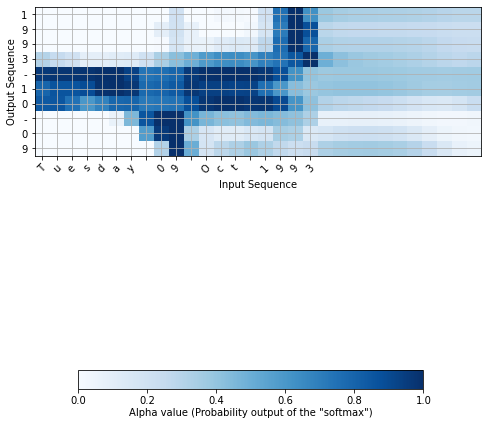

In [25]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

On the generated plot you can observe the values of the attention weights for each character of the predicted output. 
Examine this plot and check that the places where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and does not have much impact on predicting the day or month.

## References

A nice reading for this topic is for sure the original paper. In addition, we report here a nice tutorial implementation in both pytorch and tensorflow. Finally, one of the several vulgarised revisions of the paper that can be found on medium.

1. [Neural Machine Translation by jointly learning to align and translate](https://arxiv.org/pdf/1409.0473.pdf)
2. [Dive into Deep Learning](https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html)
3. [Neural Machine Translation using Bahdanau Attention Mechanism](https://medium.com/analytics-vidhya/neural-machine-translation-using-bahdanau-attention-mechanism-d496c9be30c3)